# Neustar Real-Time Fraud detection

Detecting credit card fraud by user website activity (since credit limit is given as a feature). The goal is to detect fraudulent activity based on the the users location and browser activity. The data is such that a particular user can be performing fraudulent activity on one instance, and may not be performing fraudulent activity on another. 
From the data structure, the goal seems to be to identify the fraudulent activity real-time, based on the history of site_activity, and current site activity. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from time import time

In [3]:
df = pd.read_csv('neustar_ds_test_2022.csv')

In [4]:
df.shape

(1000000, 11)

In [5]:
df.head()

,name,email,state,timestamp,geo_distance,cookie_activity_days,site_visits_A,site_visits_B,site_visits_C,credit_limit,is_fraud
0,John Anderson,robert26@graham.com,IN,2021-06-01 05:00:00.3401,338.071382,61.6,0,1,5,1400.0,0
1,John Evans,daniel90@gmail.com,MD,2021-06-01 05:00:00.4062,196.599333,66.8,1,1,4,1200.0,0
2,Anne Nelson,adrianfisher@gmail.com,NY,2021-06-01 05:00:07.8544,1009.703123,67.7,3,3,3,1700.0,1
3,Stephen Phillips,lisaesparza@holmes.com,AL,2021-06-01 05:00:10.6520,391.155132,61.5,1,1,5,5700.0,0
4,Michael Johnson,palmerkatelyn@yahoo.com,IA,2021-06-01 05:00:11.5604,778.355460,69.2,0,2,4,6900.0,0


<b><i> How much fraud is in the dataset? </i> </b>

In [6]:
df.is_fraud.value_counts() / df.is_fraud.value_counts().sum()

0    0.969907
1    0.030093
Name: is_fraud, dtype: float64

<u> Very high class imbalance </u> - There is a 3% fraud rate amongst a million fraudulent transactions 

Observing some initial statistics about each feature

In [6]:
len(df.name.unique())

330243

In [7]:
len(df.email.unique())

804105

In [8]:
df['timestamp'] = pd.to_datetime(df.timestamp,errors  = 'ignore')

In [9]:
df.timestamp.min()

'2021-06-01 05:00:00.3401'

In [10]:
df.timestamp.max()

'2021-08-31 23:59:58.3474'

All site visits are within 2 months. The grain of the timestamp is upto a second, we can probably change this based on the distribution of the data. 

<b><i> How does the fraud rate vary in the dataset? </i> </b>

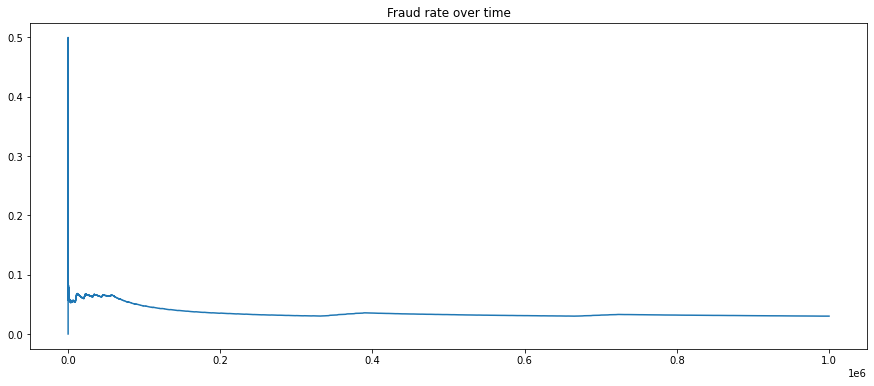

In [29]:
plt.figure(figsize = (15,6))
plt.plot(range(df.shape[0]),
         df.sort_values('timestamp',ascending = True).set_index('timestamp')['is_fraud'].cumsum() / range(df.shape[0]))
plt.title('Fraud rate over time')
plt.show()

One way to see how fraud varies in the dataset is by seeing how fraud varies over time. The sudden spike is at day 2 , and can be ignored. It looks like Fraud percentage was typically higher initially and have lowered, this might need to be accounted for in the model using some temporal features.

### Null value analysis

In [11]:
df.isna().sum()

name                        0
email                   15689
state                   18332
timestamp                   0
geo_distance             8318
cookie_activity_days     6125
site_visits_A               0
site_visits_B               0
site_visits_C               0
credit_limit                0
is_fraud                    0
dtype: int64

In [12]:
df[df.is_fraud == 1].isna().sum()

name                      0
email                   460
state                   535
timestamp                 0
geo_distance            267
cookie_activity_days    181
site_visits_A             0
site_visits_B             0
site_visits_C             0
credit_limit              0
is_fraud                  0
dtype: int64

In [13]:
df[df.is_fraud == 1].shape[0]

30093

In [14]:
460 / 30093

0.015285946897949688

In [15]:
df[df.is_fraud == 1].isna().sum().sum() / 30093

0.04795135081248131

There are na values to fill for email, state , cookie_activity_days, and geo_distance.
The initial thought was to remove these rows, however, we lose around 1.5% of the fraudulent transactions if we remove rows where email is null. 
Further if we start removing null values for state, cookie activity days and geo_distance we might end up removing about 4.7% of the fraudulent data.
While this might not seem a lot, in case of such heavy class imbalance, we might want to keep as many fraudulent transactions as possible.

There can be situations where it was hard to gather the data for fraudulent transactions, and thus we have the null values. In that case, such null values in themselves could prove quite informative. Thus, we choose to fill in the null values with informative statistical techniques, and in some cases, choose to count it as another category.

### How well are the variables distributed?

In [16]:
tab = pd.crosstab(df.email, df.is_fraud,margins = True,margins_name ='total')

In [17]:
tab.sort_values(by = [1],ascending = False)

is_fraud,0,1,total
email,,,
total,954678,29633,984311
lsmith@gmail.com,30,8,38
vsmith@gmail.com,30,6,36
ysmith@gmail.com,35,6,41
mlee@gmail.com,8,5,13
...,...,...,...
harriseric@gmail.com,2,0,2
harriseric@goodwin.com,1,0,1
harriseric@grant.com,1,0,1


In [18]:
tab = pd.crosstab(df.email, df.is_fraud)
tab = tab.sort_values(by = [1],ascending = False)

In [19]:
tab[[1]][:20][1].values

array([8, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

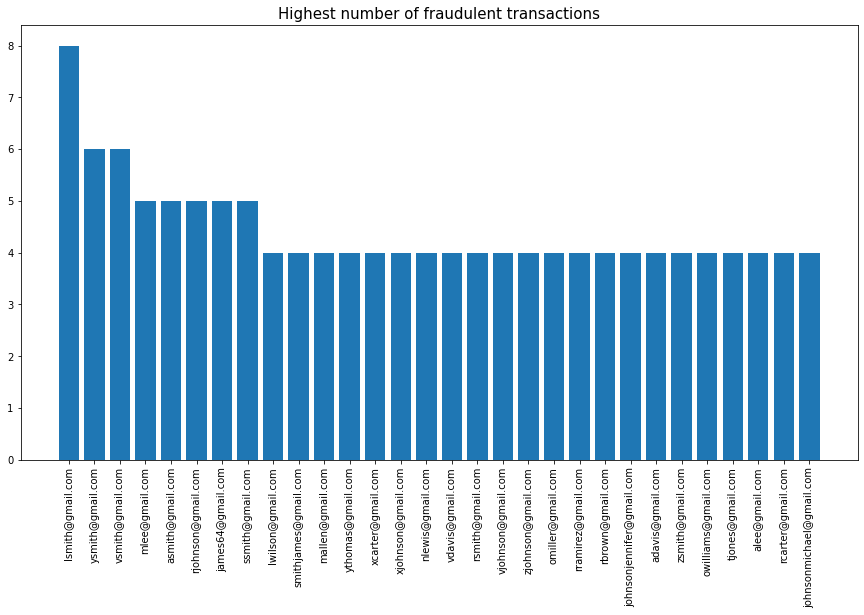

In [20]:
plt.figure(figsize = (15,8))
plt.bar(tab[[1]][:30].index,tab[[1]][:30][1].values)
plt.title('Highest number of fraudulent transactions',fontsize = 15)
plt.xticks(tab[[1]][:30].index,rotation = 90)
plt.show()

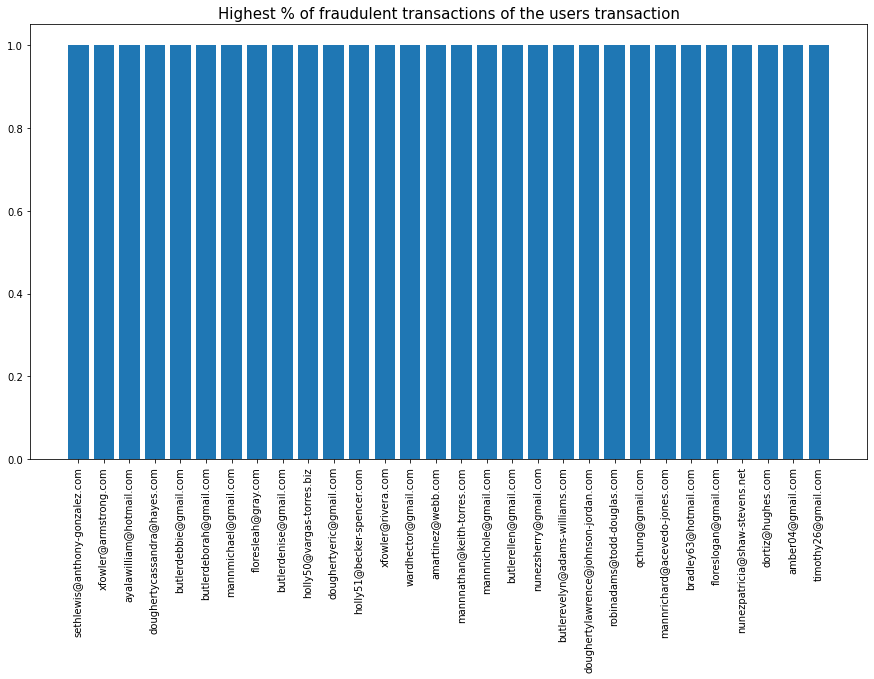

In [21]:
tab = pd.crosstab(df.email, df.is_fraud,normalize = 'index')
tab = tab.sort_values(by = [1],ascending = False)

plt.figure(figsize = (15,8))
plt.bar(tab[[1]][:30].index,tab[[1]][:30][1].values)
plt.title('Highest % of fraudulent transactions of the users transaction',fontsize = 15)
plt.xticks(tab[[1]][:30].index,rotation = 90)
plt.show()

We can see that this plot is dominated by one-time frauds. It would be interesting to see, out of the higher fraudulent transactions, who has the highest percentage of fraud of all their transactions. 
A frequency encoding scheme for this feature would give weightage to the emails that hold the most frequent fraudulent value. It can be beneficial to get a weighted score that is able to encode both new transactions as well as the most frequent. 

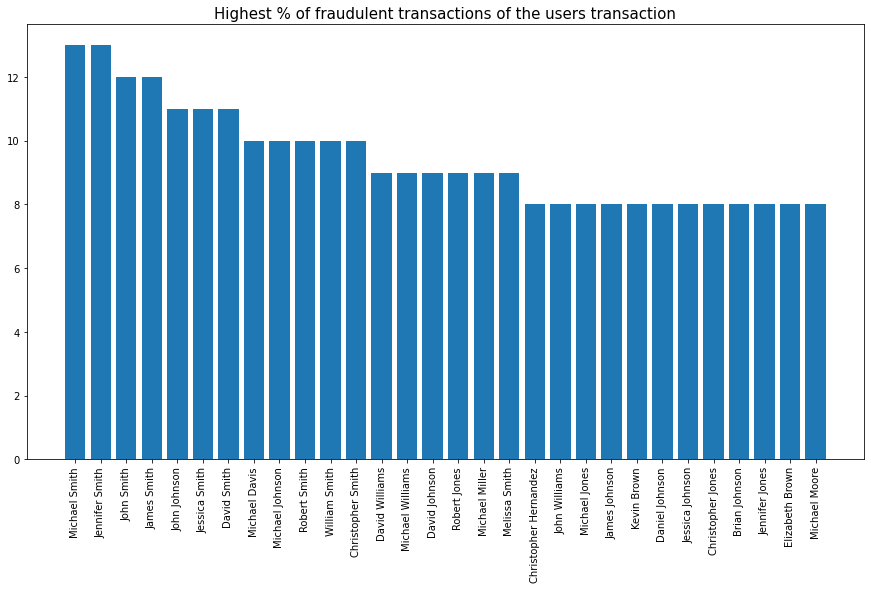

In [22]:
tab = pd.crosstab(df.name, df.is_fraud)
tab = tab.sort_values(by = [1],ascending = False)

plt.figure(figsize = (15,8))
plt.bar(tab[[1]][:30].index,tab[[1]][:30][1].values)
plt.title('Highest % of fraudulent transactions of the users transaction',fontsize = 15)
plt.xticks(tab[[1]][:30].index,rotation = 90)
plt.show()

Top frequent last names include smith, it could be possible that the fraudster has a bias to entering Smith as a surname, but we must check the distributions to confirm

In [23]:
df['first_name'] = df.name.apply(lambda x: x.split(' ')[0])
df['last_name'] = df.name.apply(lambda x: x.split(' ')[1])

In [24]:
len(df.last_name.unique())

1583

In [25]:
len(df.first_name.unique())

695

In [26]:
df.last_name.value_counts()

Smith       21423
Johnson     16668
Williams    13571
Brown       12301
Jones       12295
            ...  
Selena          1
Jade            1
Jasmin          1
Fred            1
Leroy           1
Name: last_name, Length: 1583, dtype: int64

Smith is the most widely used surname, and thus the most fraudulent transactions have Smith in them. 
It's hard to establish any direct relation between the 2. 

In [27]:
df[df.is_fraud == 1].last_name.value_counts()

Smith       635
Johnson     514
Williams    405
Jones       382
Brown       361
           ... 
Troy          1
Dylan         1
Shelby        1
Glenda        1
Adam          1
Name: last_name, Length: 1227, dtype: int64

In [28]:
df.first_name.value_counts()

Michael     22212
David       15241
James       14485
Jennifer    14382
John        13852
            ...  
Neil          109
Gregg         102
Terrance       99
Darin          97
Terrence       93
Name: first_name, Length: 695, dtype: int64

In [29]:
df[df.is_fraud == 1].first_name.value_counts()

Michael        669
David          448
James          429
Christopher    428
John           406
              ... 
Marisa           1
Dan              1
Dave             1
Summer           1
Kirsten          1
Name: first_name, Length: 694, dtype: int64

In [30]:
df[df.is_fraud == 1].state.value_counts()[:10] 

WY    10492
MO     6854
NY     4472
GA      192
RI      190
WI      189
NM      182
TX      181
VT      181
AL      180
Name: state, dtype: int64

It's interesting to see that WY, MO and NY dominate the fraudulent transactions. 
NY might just be in the list because of sheer volume of transactions.

In [31]:
(df[df.is_fraud == 1].state.value_counts() / df.state.value_counts()).sort_values(ascending = False)[:10]

WY    0.359069
MO    0.268795
NY    0.192900
GA    0.010205
RI    0.010131
WI    0.010074
NM    0.009655
VT    0.009645
AL    0.009573
TX    0.009564
Name: state, dtype: float64

<u> Wyoming definitely has a higher rate of fraud </u>

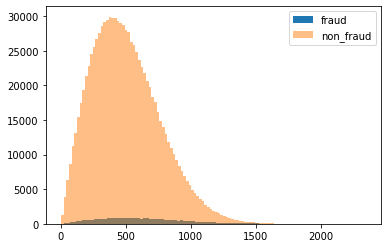

In [32]:
x = df[df.is_fraud == 1].geo_distance
y = df[df.is_fraud == 0].geo_distance

plt.hist(x,bins = 100,  alpha=1, label='fraud')
plt.hist(y, bins = 100, alpha=0.5, label='non_fraud')
plt.legend(loc='best')
plt.show()

<AxesSubplot:>

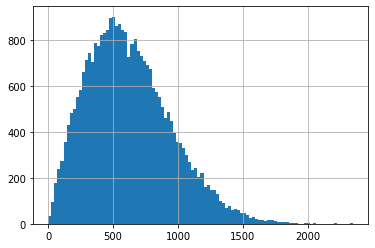

In [33]:
df[df.is_fraud == 1].geo_distance.hist(bins = 100)

Geo Distance seems like it's pretty even;y distributed across geoDistance values

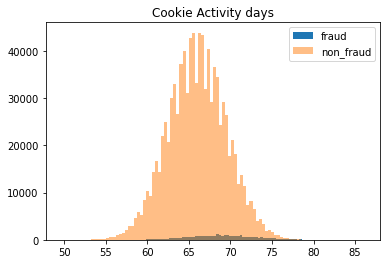

In [34]:
x = df[df.is_fraud == 1].cookie_activity_days
y = df[df.is_fraud == 0].cookie_activity_days

plt.hist(x,bins = 100,  alpha=1, label='fraud')
plt.hist(y, bins = 100, alpha=0.5, label='non_fraud')
plt.title('Cookie Activity days')
plt.legend(loc='best')
plt.show()

Assuming a normal distributon for cookie_activity, It is clearly visible that the mean of the cookie activity is higher in case of fraudulent transactions ~ 70 days, 
while for non fraudulent the mean is around 65-67. 

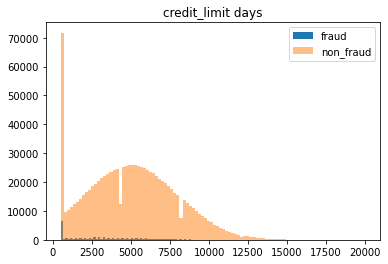

In [35]:
x = df[df.is_fraud == 1].credit_limit
y = df[df.is_fraud == 0].credit_limit

plt.hist(x, bins = 100,  alpha=1, label='fraud')
plt.hist(y, bins = 100, alpha=0.5, label='non_fraud')
plt.title('credit_limit days')
plt.legend(loc='best')
plt.show()

It looks like a lot users have a lower credit limit

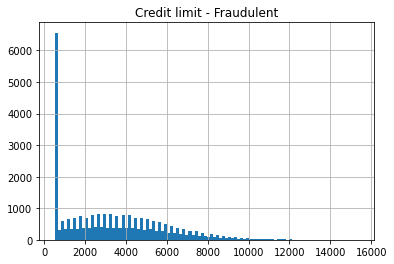

In [36]:
df[df.is_fraud == 1].credit_limit.hist(bins= 100)
plt.title('Credit limit - Fraudulent')
plt.show()

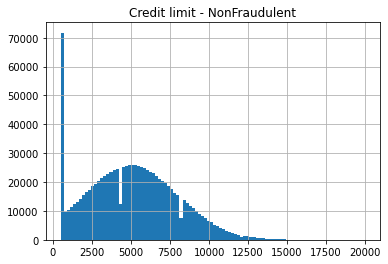

In [37]:
df[df.is_fraud == 0].credit_limit.hist(bins= 100)
plt.title('Credit limit - NonFraudulent')
plt.show()

It is also visible that <b> higher </b> credit limits are less likely to be fraudulent

#### Site visit analysis and their combinations

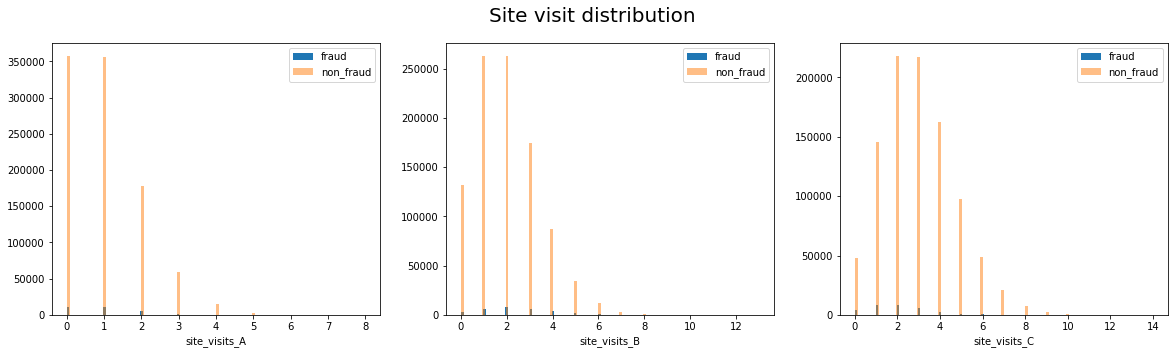

In [38]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.set_size_inches((20,5))
fig.suptitle('Site visit distribution',fontsize = 20)
site_visits = ['site_visits_A','site_visits_B','site_visits_C']

count = 0
for ax in (ax1,ax2,ax3):
    ax.hist(df[df.is_fraud == 1][site_visits[count]], bins = 100,  alpha=1, label='fraud')
    ax.hist(df[df.is_fraud == 0][site_visits[count]], bins = 100, alpha=0.5, label='non_fraud')
    ax.set_xlabel(site_visits[count]) 
    ax.legend(loc = 'best')
    count += 1

plt.show()

In general the mean of these distributions is around 1 or 2 for fraudulent as well as non-fraudulent. We might have to be smarter in identifying the relation of this feature to fraud, maybe testing some combinations of when they occur together. This is a good candidate for generating Polynomial features, or using SVMs with polymial kernels / Neural Networks and thus our column transformation steps would include transforms for all these features.

### How do we identify history of users? What does a unique user mean? 

In [39]:
df = df.sort_values(by = 'timestamp', ascending = True)

In [40]:
df.groupby(['name','email','state']).count()['is_fraud'][df.groupby(['name','email','state']).count()['is_fraud'] > 1]

name          email               state
Thomas Hogan  rwheeler@gmail.com  OH       2
Name: is_fraud, dtype: int64

Thus, there is not much scope of time series, moving average kind of feature generation given that a particular user in a particular state 
with a particular email ID does not create a time series.

Thus entity (user) identification, needs to be given a thought. We neede  a sense of what is the unique identifier. 
Name can be duplicated, so is email ID, we need more information from the busines / database programmers as to what can be regarded as the unique identifiers, on which transactions can be viewed as a time series.

If we assume that a particular user can be identified using name and email what are the time series counts like? 

In [41]:
df.groupby(['name','email']).count()['is_fraud'][df.groupby(['name','email']).count()['is_fraud'] > 1]

name           email                  
Brian James    adrianyoung@hotmail.com    2
Brian Smith    qwilson@hotmail.com        2
John Foster    bsmith@gmail.com           2
John Garcia    jamestaylor@hotmail.com    2
Michael Brown  gbrown@hotmail.com         2
Thomas Hogan   rwheeler@gmail.com         2
Name: is_fraud, dtype: int64

Thus , we have only 7 of such time series, which might not add value as features. We can probably create a time series based on a users name or email, but it could be useful to do that knowing which ID is unique/reliable.

### Feature engineering and elimination

In [42]:
df['site_visits_all'] = df['site_visits_A'] + df['site_visits_B'] + df['site_visits_C']

In [43]:
df.drop(['name'],inplace = True,axis = 1)

In [44]:
df['timestamp'] = pd.to_datetime(df.timestamp,errors = 'coerce')

In [45]:
df[df.timestamp.isna()]['is_fraud']

802326    0
Name: is_fraud, dtype: int64

We can safely remove this fraudulent transaction, if this were fraudulent we could have built business rules on how this could be removed.

### Data imputation strategy 

1. <u>Email</u> - Treat as new value
2. <u>State</u> - Randomly sample from existing multinomial distribution
3. <u>Timestamp</u> - Remove row. 
4. <u>GeoDistance</u> - Randomly Sample from assuming normal distribution
5. <u>CookieActivity</u> - Randomly Sample from existing CDF distribution

In [46]:
df = df[df.timestamp.notna()]

In [47]:
cumdist_state = (df.state.value_counts() / df.shape[0]).cumsum()

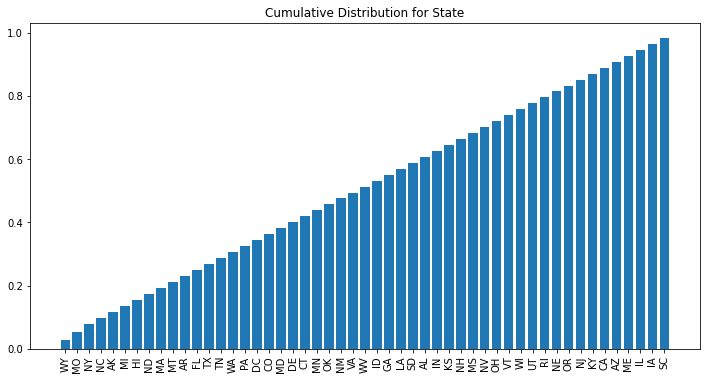

In [48]:
plt.figure(figsize = (12,6))
plt.title('Cumulative Distribution for State')
plt.bar(cumdist_state.index,cumdist_state.values)
plt.xticks(cumdist_state.index,rotation = 90)
plt.show()

Sampling from cumulative distribution will not work for this function, since this variable follows a multinomial distribution.

In [49]:
cumdist_cookie = (df.cookie_activity_days.value_counts() / df.shape[0]).sort_index(ascending = True).cumsum()

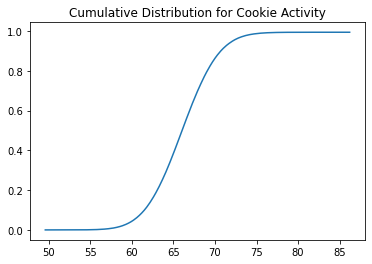

In [50]:
plt.plot(cumdist_cookie)
plt.title('Cumulative Distribution for Cookie Activity')
plt.show()

In [51]:
from scipy.interpolate import interp1d

func = interp1d(cumdist_cookie.values,cumdist_cookie.index,kind = 'cubic')

In [100]:
func(np.random.uniform()).tolist()

70.13641334919463

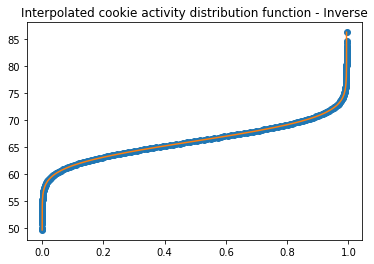

In [52]:
xnew = cumdist_cookie.values
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.title('Interpolated cookie activity distribution function - Inverse')
plt.plot(cumdist_cookie.values, cumdist_cookie.index, 'o', xnew, ynew, '-')
plt.show()

In [53]:
mu = df.geo_distance.mean()
sigma = df.geo_distance.std()

In [103]:
def sample_geo():
    '''
    Normally distributed imputation for geodistance
    '''
    return np.random.normal(loc = mu,scale = sigma)

def sample_cookie():
    '''
    Sampling from cumulative distribution
    '''
    u = np.random.uniform(low = 0.05,high = 0.95)
    return func(u).tolist()

def sample_state():
    '''
    Sample state according to the distribution
    '''
    chosen = np.argwhere(np.random.multinomial(1,(df.state.value_counts() / df.shape[0])) == 1)[0][0]
    return cumdist_state.index[chosen]

In [55]:
import dask.dataframe as dd

ddf = dd.from_pandas(df,npartitions = 128)

In [124]:
ddf['email'] = ddf.email.apply(lambda x: 'NA' if x is np.nan else x)
print('Email imputation initiated')
ddf['state'] = ddf.state.apply(lambda x: sample_state() if x is np.nan else x)
print('State imputation initiated')
ddf['cookie_activity_days'] = df.cookie_activity_days.apply(lambda x: sample_cookie() if (x is np.nan or np.isnan(x)) else x)
print('Cookie activity days initiated')
ddf['geo_distance'] = ddf.geo_distance.apply(lambda x: sample_geo() if (x is np.nan or np.isnan(x)) else x)
print('Geo Distance initiated')

/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/dask/dataframe/core.py:3858: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('email', 'object'))

  warnings.warn(meta_warning(meta))
/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/dask/dataframe/core.py:3858: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, m

Email imputation initiated
State imputation initiated
Cookie activity days initiated
Geo Distance initiated


/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/dask/dataframe/core.py:3858: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('geo_distance', 'float64'))

  warnings.warn(meta_warning(meta))


In [125]:
df = ddf.compute()

In [126]:
df.isna().sum()

email                   0
state                   0
timestamp               0
geo_distance            0
cookie_activity_days    0
site_visits_A           0
site_visits_B           0
site_visits_C           0
credit_limit            0
is_fraud                0
first_name              0
last_name               0
site_visits_all         0
dtype: int64

In [130]:
df['month'] = df.timestamp.apply(lambda x: x.month)
df['day'] = df.timestamp.apply(lambda x: x.day)
df['hour'] = df.timestamp.apply(lambda x: x.hour)

### Here, we assume that fraudulent transactions wouldn't have any cycles by minute.

In [132]:
df.drop('timestamp',axis = 1,inplace = True)

In [161]:
def transform_email(x):
    e = x.split('@')
    try:
        return e[1]
    except:
        return ''
    
def transform_email_server(x):
    e = x.split('@')
    try:
        return e[0]
    except:
        return ''

def transform_domain(x):
    e = x.split('.')
    try:
        return e[1]
    except:
        return ''
    
emails = df.email.apply(lambda x: transform_email(x))

In [150]:
len(emails.unique())

141153

### 141153 unique servers!

In [152]:
domains = emails.apply(lambda x: transform_domain(x))

In [153]:
tab = pd.crosstab(emails,df.is_fraud)
tab = tab.sort_values(1,ascending = False)

In [156]:
tab = pd.crosstab(emails,df.is_fraud,normalize = 'index')
tab = tab.sort_values(1,ascending = False)
tab

is_fraud,0,1
email,,
steele-faulkner.com,0.0,1.0
mitchell-chavez.net,0.0,1.0
brown-jones.biz,0.0,1.0
parker-swanson.org,0.0,1.0
silva-bond.com,0.0,1.0
...,...,...
gutierrez-russo.com,1.0,0.0
gutierrez-rojas.com,1.0,0.0
gutierrez-rogers.org,1.0,0.0


In [157]:
domains.value_counts()

com     789871
org      48865
net      48566
info     48505
biz      48503
         15689
Name: email, dtype: int64

In [159]:
domains[df.is_fraud == 1].value_counts()

com     25791
net       986
org       982
info      967
biz       907
          460
Name: email, dtype: int64

#### Thus, the above distributions show that there is no specific pattern in email id's that fraudulent people follow, and this may not be one of our most important features.

In [160]:
df['domain'] = domains

In [162]:
df['email_server'] = df.email.apply(lambda x: transform_email_server(x))

In [164]:
# Name present in email

email                   0
state                   0
geo_distance            0
cookie_activity_days    0
site_visits_A           0
site_visits_B           0
site_visits_C           0
credit_limit            0
is_fraud                0
first_name              0
last_name               0
site_visits_all         0
month                   0
day                     0
hour                    0
domain                  0
email_server            0
dtype: int64

In [174]:
def name_email(x):
    if x['first_name'].lower() in x['email'] or x['last_name'].lower() in x['email']:
        return True
    else:
        return False
    
def name_plus_email(x):
    if x['first_name'].lower() in x['email'] and x['last_name'].lower() in x['email']:
        return True
    else:
        return False

df['either_name_in_email'] = df.apply(name_email,axis = 1)
df['both_name_in_email'] = df.apply(name_plus_email,axis = 1)

In [173]:
df.name_in_email.value_counts()

False    989216
True      10783
Name: name_in_email, dtype: int64

In [175]:
df.both_name_in_email.value_counts()

False    999957
True         42
Name: both_name_in_email, dtype: int64

In [178]:
import re

df['email_has_number'] = df.email.apply(lambda x: bool(re.search(r'\d', x)))

In [180]:
df['email_has_number'].value_counts()

False    753402
True     246597
Name: email_has_number, dtype: int64

In [182]:
df.drop('email',inplace = True,axis = 1)

In [183]:
df.columns

Index(['state', 'geo_distance', 'cookie_activity_days', 'site_visits_A',
       'site_visits_B', 'site_visits_C', 'credit_limit', 'is_fraud',
       'first_name', 'last_name', 'site_visits_all', 'month', 'day', 'hour',
       'domain', 'email_server', 'name_in_email', 'either_name_in_email',
       'both_name_in_email', 'email_has_number'],
      dtype='object')

In [263]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

from category_encoders import OneHotEncoder, TargetEncoder, CatBoostEncoder


ct = ColumnTransformer(
    [('state_encoder',TargetEncoder(),['state']),
     ('first_name',CatBoostEncoder(),['first_name']),
     ('last_name',CatBoostEncoder(),['last_name']),
     ('mail_server',TargetEncoder(),['email_server']),
     ('domain',CatBoostEncoder(),['domain']),
     ('site_visits',PolynomialFeatures(degree = 2),['site_visits_A','site_visits_B','site_visits_C']),
     ('scaling',StandardScaler(),['geo_distance','credit_limit','cookie_activity_days'])
    ],remainder = 'passthrough'
)

In [264]:
X = ct.fit_transform(df.drop('is_fraud',axis = 1),df['is_fraud'])
Y = df['is_fraud']

In [265]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(X,Y,stratify = Y,random_state=42)

In [308]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

### Sampling Strategy
The sampling strategy we choose is such that data is undersampled from the majority class only, leaving all minority classes as is. We choose sampling_strategy 0.4 to keep some imbalance so that we're not suprised by Out Of Bag Evaluation. 

In [267]:
pip = Pipeline([('rus', RandomUnderSampler(sampling_strategy=0.4,random_state=42)),
          ('model',RandomForestClassifier())
         ])

In [268]:
pip.fit(train_x,train_y)

Pipeline(steps=[('rus',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4)),
                ('model', RandomForestClassifier())])

In [269]:
pip[1].score(test_x,test_y)

0.96148

In [270]:
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(test_y,pip[1].predict(test_x))

0.9118776027164642

In [271]:
curve = roc_curve(test_y,pip[1].predict(test_x),drop_intermediate = False)

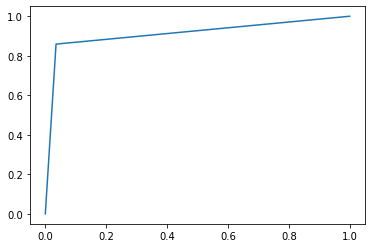

In [272]:
plt.plot(curve[0],curve[1])

#### Building our own 10 point ROC curve

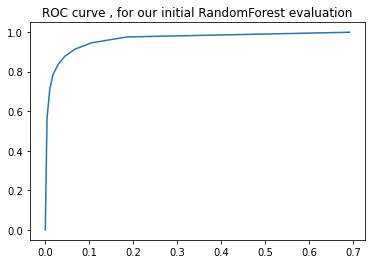

In [253]:
def fetch_roc(pip):
    thresholds = np.linspace(0,1,10)
    tprs = []
    tnrs = []

    for t in thresholds:
        preds = (pip.predict_proba(test_x)[:,1] > t)

        tp = ((preds == test_y) & (test_y == 1)).sum()
        fp = ((preds != test_y) & (test_y == 0)).sum()
        tn = ((preds == test_y) & (test_y == 0)).sum()
        fn = ((preds != test_y) & (test_y == 1)).sum()

        tprs.append(tp / (tp + fn)) # True positive Rate
        tnrs.append(fp / (tn + fp)) # False positive Rate
        
    return tnrs,tprs,thresholds

tnrs,tprs,thresholds = fetch_roc(pip)
plt.plot(tnrs,tprs)
plt.title('ROC curve , for our initial RandomForest evaluation')
plt.show()

Initial feature importance graphs.

In [286]:
features = list()

for c in ct.transformers_[:-2]:
    features += c[1].get_feature_names()

In [298]:
features += list(ct.transformers_[-2][1].get_feature_names_out())

In [ ]:
for c in ct.transformers_[-1][2]:
    features += [df.columns[c]]

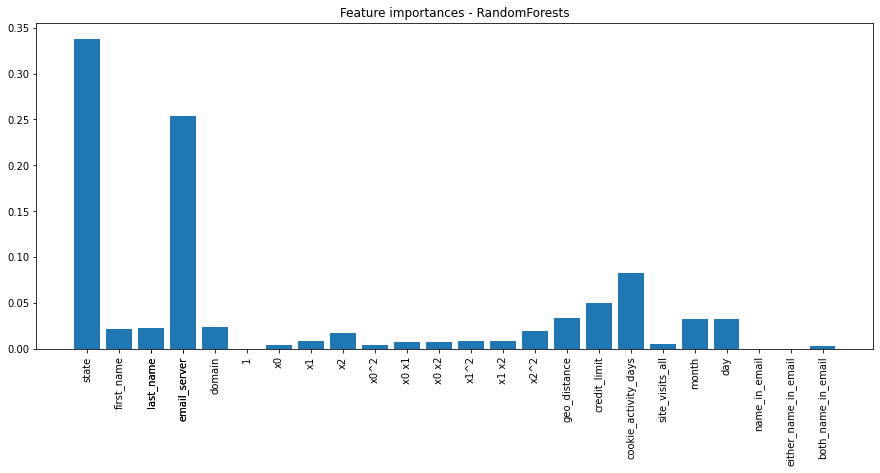

In [307]:
plt.figure(figsize= (15,6))
plt.bar(features,pip[1].feature_importances_)
plt.xticks(features,rotation = 90)
plt.title('Feature importances - RandomForests')
plt.show()

As suspected in the EDA, state turns out to be the most important feature according to entropy calculations by RandomForests, and proves to be the strongest predictor, along with the email ID server. 

Checking if any model outperforms the other in terms of AUC, on different subsets of train and test.

In [317]:
from sklearn.model_selection import cross_val_score

x,y = RandomUnderSampler(sampling_strategy=0.4,random_state=42).fit_resample(X,Y)

for classifier in [KNeighborsClassifier(),GradientBoostingClassifier(),LogisticRegression(), RandomForestClassifier()]:
    print('%.2f' % np.mean(cross_val_score(classifier, x, y, # Number of folds in the dataset.
                                 scoring = 'roc_auc',cv=4))
         )

0.70
0.90


/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

0.95
0.91


#### It looks like Logisitic Regression has a really good average ROC_AUC! 

Thus, in order to keep model explaination simple, we select <b> LOGISTIC REGRESSION </b> as our final model. 

Moving on to hyperparameter tuning.

In [319]:
from sklearn.model_selection import RandomizedSearchCV

lr = LogisticRegression()
search = RandomizedSearchCV(lr,{'penalty':['l1','l2','elastic'],
                        'C':[0.1,0.5,1]}, scoring = 'roc_auc')
search.fit(train_x,train_y)

/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incr

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': [0.1, 0.5, 1],
                                        'penalty': ['l1', 'l2', 'elastic']},
                   scoring='roc_auc')

In [320]:
final_model = search.best_estimator_

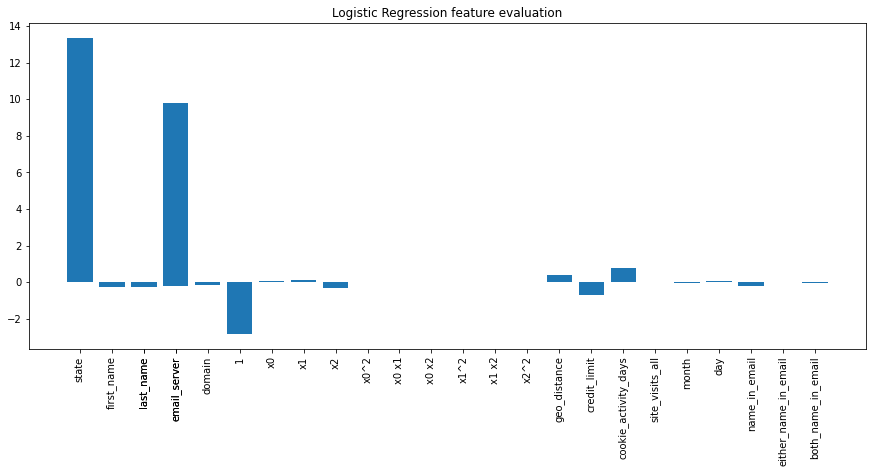

In [332]:
plt.figure(figsize = (15,6))
plt.bar(features,final_model.coef_[0])
plt.title('Logistic Regression feature evaluation')
plt.xticks(features,rotation = 90)
plt.show()

#### Thus, there is consensus between the most important feature in the dataset being state and the email server. We also gather that there are features that we could definitely drop, such as some of the polymial features, and also there is scope to analyze the email feature as it originally was. 

In [350]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from imblearn.pipeline import make_pipeline

print('Final Classifier scores: ') 

lr = make_pipeline(RandomUnderSampler(0.4),LogisticRegression())
lr.fit(train_x,train_y) # Not undersampled that's why.
preds = lr.predict(test_x)

print(
''' 
Accuracy %.2f
Precision %.2f
Recall %.2f
F1-score %.2f
ROC AUC %.2f
''' % (accuracy_score(test_y,preds),
       precision_score(test_y,preds),
       recall_score(test_y,preds),
       f1_score(test_y,preds),
       roc_auc_score(test_y,preds),
      ))

Final Classifier scores: 


/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.4 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 
Accuracy 0.96
Precision 0.39
Recall 0.80
F1-score 0.52
ROC AUC 0.88



Thus, our final model has a very high recall, meaning that we're calling of frauds 80% of the times, however, the precision is really low.
Further feature elimination and better sampling techniques could be thought of to get that score balanced. However this is always going to be a tradeoff and we must choose wisely in a production environment, based on experiments